# Download and analyse the latest river water quality information by catchment

### 1. Download water quality data for the area of interest

First we load the packages we're going to need

In [1]:
import geopandas as gpd
import pandas as pd
import io
import requests
import folium
from shapely.geometry import shape
print('Set-up completed')

Set-up completed


Then download the polygons and associated name and code for the River Wye management catchment from the Environment Agency Catchment Data API.

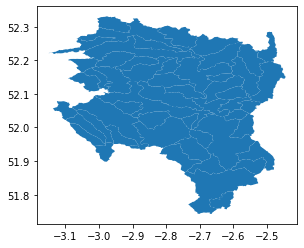

In [2]:
# get list of waterbodies in Wye catchment
wb_list_url = "https://environment.data.gov.uk/catchment-planning/so/WaterBody.csv?inRiverBasinDistrict=3"
wb = requests.get(wb_list_url).content
wbs = pd.read_csv(io.StringIO(wb.decode('utf-8')))

# download polygons for each waterbody catchment
for i in list(wbs['isVersionOf']):
    poly_url = i + '/polygon'
    poly = requests.get(poly_url)
    wbs.loc[wbs['isVersionOf']==i,'geometry']= shape(poly.json())
    
# create geodataframe and plot catchments
wbs_gdf = gpd.GeoDataFrame(wbs, crs="EPSG:4326")
wbs_gdf.plot()

Now let's download the water quality data for the Wye catchment for the period 2000-2019 using the Environment Agency Water Quality API.

In [11]:
# Download site information for EA area with Wye catchment in it
pointUrl="http://environment.data.gov.uk/water-quality/id/sampling-point.csv?_limit=100000&_view=full&area=2-31&samplingPointType.group=F"
s=requests.get(pointUrl).content
sites=pd.read_csv(io.StringIO(s.decode('utf-8')))
sites_gdf = gpd.GeoDataFrame(sites, geometry=gpd.points_from_xy(sites.long, sites.lat))
sites_gdf.crs = "EPSG:4326"

sites_wb = gpd.sjoin(sites_gdf, wbs_gdf, how="inner", op='intersects')

Now let's plot a map of the catchment and the available data points.

In [12]:
centroid = wbs_gdf.geometry.centroid
m = folium.Map(location=[centroid.y.mean(), centroid.x.mean()], zoom_start=9)

wb_layer = folium.GeoJson(wbs_gdf[['geometry','label']],
               name='Waterbodies',
               tooltip=folium.features.GeoJsonTooltip(
                       fields=['label',],
                       aliases=['WB name:'])
               ).add_to(m)

sites_g = folium.map.FeatureGroup(name='Sites')
for row in sites_wb.itertuples(index=False):
    sites_g.add_child(folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=5, fill_color='blue', fill=True, color='blue', fill_opacity=0.6))
sites_g.add_to(m)

display(m)